In [ ]:
!pip install scipy
!pip install numpy

In [1]:
import pandas as pd
import numpy as np
import scipy
import ast
from geopy.distance import geodesic
import geopandas as gpd 
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from scipy.spatial.distance import cdist
pd.set_option('display.max_columns', None)


***
**Elections**
***

In [ ]:
elections = pd.read_csv('merged_elections (2).csv',sep=';')
columns = [
    "Unnamed: 0",
    "Abstentions",
    "Blancs et nuls",
    "Exprimés",
    "Inscrits",
    "Votants",
    "department_name",
    "voix_eco",
    "% Voix/Ins_eco",
    "Blancs",
    "Nuls"
]
elections = elections.drop(columns, axis=1)

In [3]:
elections = elections[elections['election_type']!="reg"]
elections = elections[elections['election_type']!="legis"]
elections = elections.dropna(subset=['election_type'])
elections

,department_number,city_code,% Voix/Exp_eco,election_type,election_day,code_insee
0,1,L'Abergement-Clémenciat,13.90,europ,20090607,01001
1,1,L'Abergement-de-Varey,21.70,europ,20090607,01002
2,1,Ambérieu-en-Bugey,16.12,europ,20090607,01004
3,1,Ambérieux-en-Dombes,13.93,europ,20090607,01005
4,1,Ambléon,14.58,europ,20090607,01006
...,...,...,...,...,...,...
321937,ZZ,Zurich,9.28,presid,20220410,ZZ229
321938,ZZ,Taipei,10.83,presid,20220410,ZZ231
321939,ZZ,Nour-Soultan,7.84,presid,20220410,ZZ233
321940,ZZ,Monterrey,6.33,presid,20220410,ZZ234


In [4]:
#keep only if department_number is between 1 and 99 or equal to 2A or 2B
elections = elections[elections['department_number'].str.match(r'^([1-9]|[0-9][0-9]|2A|2B)$')]
#Modify the value in column election_day from 20120611 to 20170611
elections['election_day'] = elections['election_day'].replace(20120611, 20170611)
elections

C:\Users\mathys.bodelet\AppData\Local\Temp\ipykernel_41104\2026396534.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elections['election_day'] = elections['election_day'].replace(20120611, 20170611)


,department_number,city_code,% Voix/Exp_eco,election_type,election_day,code_insee
0,1,L'Abergement-Clémenciat,13.90,europ,20090607,01001
1,1,L'Abergement-de-Varey,21.70,europ,20090607,01002
2,1,Ambérieu-en-Bugey,16.12,europ,20090607,01004
3,1,Ambérieux-en-Dombes,13.93,europ,20090607,01005
4,1,Ambléon,14.58,europ,20090607,01006
...,...,...,...,...,...,...
321512,95,Villers-en-Arthies,4.73,presid,20220410,95676
321513,95,Villiers-Adam,6.00,presid,20220410,95678
321514,95,Villiers-le-Bel,1.12,presid,20220410,95680
321515,95,Villiers-le-Sec,2.11,presid,20220410,95682


In [5]:
depanelized_data = elections.groupby('code_insee').agg({
    '% Voix/Exp_eco': list,  # Create a list of results
    'election_type': list,
    'election_day': list,   # Create a list of election types
}).reset_index()

# Rename the columns as needed
depanelized_data = depanelized_data.rename(columns={
    '% Voix/Exp_eco': 'elections_result',
    'election_type': 'elections_types',
    'election_day': 'elections_days',
})

# Check the result
depanelized_data

,code_insee,elections_result,elections_types,elections_days
0,01001,"[13.9, 6.11, 17.52, 1.92, 2.61, 5.86, 5.77]","[europ, europ, europ, presid, presid, presid, ...","[20090607, 20140525, 20190525, 20070422, 20120..."
1,01002,"[21.7, 20.16, 28.89, 2.34, 5.75, 7.39, 5.85]","[europ, europ, europ, presid, presid, presid, ...","[20090607, 20140525, 20190525, 20070422, 20120..."
2,01004,"[16.12, 7.73, 13.84, 1.48, 1.94, 5.33, 4.38]","[europ, europ, europ, presid, presid, presid, ...","[20090607, 20140525, 20190525, 20070422, 20120..."
3,01005,"[13.93, 4.28, 13.3, 1.55, 1.66, 3.97, 3.99]","[europ, europ, europ, presid, presid, presid, ...","[20090607, 20140525, 20190525, 20070422, 20120..."
4,01006,"[14.58, 5.77, 10.77, 0.0, 3.45, 3.9, 2.6]","[europ, europ, europ, presid, presid, presid, ...","[20090607, 20140525, 20190525, 20070422, 20120..."
...,...,...,...,...
36571,95676,"[17.37, 7.96, 11.96, 1.55, 2.88, 2.99, 4.73]","[europ, europ, europ, presid, presid, presid, ...","[20090607, 20140525, 20190525, 20070422, 20120..."
36572,95678,"[15.91, 4.49, 14.72, 1.45, 2.69, 5.05, 6.0]","[europ, europ, europ, presid, presid, presid, ...","[20090607, 20140525, 20190525, 20070422, 20120..."
36573,95680,"[10.23, 8.27, 9.68, 1.06, 1.16, 8.51, 1.12]","[europ, europ, europ, presid, presid, presid, ...","[20090607, 20140525, 20190525, 20070422, 20120..."
36574,95682,"[13.21, 5.48, 19.67, 2.13, 0.0, 9.43, 2.11]","[europ, europ, europ, presid, presid, presid, ...","[20090607, 20140525, 20190525, 20070422, 20120..."


***
**Data Import**
***

In [ ]:
commune = pd.read_csv('dossier_complet.csv',sep=';')
densite_commune = pd.read_excel('grille_densite_7_niveaux_2024 (1).xlsx')
coordonnees = pd.read_csv('cities.csv')

In [93]:
variable_of_choice = [
    'CODGEO', 'SUPERF',
    'P21_POP', 'P15_POP', 'P10_POP',
    'P21_POP0014', 'P15_POP0014', 'P10_POP0014',
    'P21_POP1529', 'P15_POP1529', 'P10_POP1529',
    'P21_POP3044', 'P15_POP3044', 'P10_POP3044',
    'P21_POP4559', 'P15_POP4559', 'P10_POP4559',
    'P21_POP6074', 'P15_POP6074', 'P10_POP6074',
    'P21_POP7589', 'P15_POP7589','P10_POP75P',
    'P21_POP90P', 'P15_POP90P',
    'P21_POPH', 'P15_POPH', 'P10_POPH',
    'P21_POPF', 'P15_POPF', 'P10_POPF',
    'C21_POP15P', 'C15_POP15P', 'C10_POP15P',
    'C21_POP15P_CS1', 'C15_POP15P_CS1', 'C10_POP15P_CS1',
    'C21_POP15P_CS2', 'C15_POP15P_CS2', 'C10_POP15P_CS2',
    'C21_POP15P_CS3', 'C15_POP15P_CS3', 'C10_POP15P_CS3',
    'C21_POP15P_CS4', 'C15_POP15P_CS4', 'C10_POP15P_CS4',
    'C21_POP15P_CS5', 'C15_POP15P_CS5', 'C10_POP15P_CS5',
    'C21_POP15P_CS6', 'C15_POP15P_CS6', 'C10_POP15P_CS6',
    'C21_POP15P_CS7', 'C15_POP15P_CS7', 'C10_POP15P_CS7',
    'C21_POP15P_CS8', 'C15_POP15P_CS8', 'C10_POP15P_CS8',
    'C21_H15P', 'C15_H15P', 'C10_H15P',
    'C21_F15P', 'C15_F15P', 'C10_F15P',
    'C21_MEN', 'C15_MEN', 'C10_MEN',
    'C21_MENCOUPSENF', 'C15_MENCOUPSENF', 'C10_MENCOUPSENF',
    'C21_MENCOUPAENF', 'C15_MENCOUPAENF', 'C10_MENCOUPAENF',
    'C21_MENFAMMONO', 'C15_MENFAMMONO', 'C10_MENFAMMONO',
    'C21_ACT1564_CS1', 'C15_ACT1564_CS1', 'C10_ACT1564_CS1',
    'C21_ACT1564_CS2', 'C15_ACT1564_CS2', 'C10_ACT1564_CS2',
    'C21_ACT1564_CS3', 'C15_ACT1564_CS3', 'C10_ACT1564_CS3',
    'C21_ACT1564_CS4', 'C15_ACT1564_CS4', 'C10_ACT1564_CS4',
    'C21_ACT1564_CS5', 'C15_ACT1564_CS5', 'C10_ACT1564_CS5',
    'C21_ACT1564_CS6', 'C15_ACT1564_CS6', 'C10_ACT1564_CS6',
    'P21_LOG', 'P15_LOG', 'P10_LOG',
    'P21_RP', 'P15_RP', 'P10_RP',
    'P21_RSECOCC', 'P15_RSECOCC', 'P10_RSECOCC',
    'P21_LOGVAC', 'P15_LOGVAC', 'P10_LOGVAC',
    'P21_MAISON', 'P15_MAISON', 'P10_MAISON',
    'P21_APPART', 'P15_APPART', 'P10_APPART',
]
commune = commune[variable_of_choice]
commune['P10_density'] = commune['P10_POP'] / commune['SUPERF']
commune['P15_density'] = commune['P15_POP'] / commune['SUPERF']
commune['P21_density'] = commune['P21_POP'] / commune['SUPERF']


In [94]:
densite_commune = densite_commune.drop([0, 1])
densite_commune.columns = densite_commune.iloc[0]
densite_commune = densite_commune.drop([2])
densite_commune = densite_commune.drop([3])
densite_commune.reset_index(drop=True, inplace=True)
densite_commune.rename(columns={'\nCode \nCommune\n': 'CODGEO'}, inplace=True)

commune['CODGEO'] = commune['CODGEO'].astype(str).str.zfill(5)
densite_commune['CODGEO'] = densite_commune['CODGEO'].astype(str).str.zfill(5)
commune_and_density = commune.merge(densite_commune, how='left', on='CODGEO')
commune_and_density = commune_and_density.dropna(subset=['SUPERF'])
coordonnees['insee_code'] = coordonnees['insee_code'].astype(str).str.zfill(5)
dataset = commune_and_density.merge(
    coordonnees,
    how='left',
    left_on='CODGEO',
    right_on='insee_code'
)
dataset.rename(columns={'Typo degré de \nDensité\n': 'type_densite'}, inplace=True)

In [95]:
depanelized_data['code_insee'] = depanelized_data['code_insee'].astype(str)
#if 0 is the first character, we need to remove it
depanelized_data['code_insee'] = depanelized_data['code_insee'].str.zfill(5)
dataset['CODGEO'] = dataset['CODGEO'].astype(str).str.zfill(5)
merged_dataset = dataset.merge(depanelized_data, left_on='CODGEO', right_on='code_insee', how='left')
#Delete the row where code_insee in NaN
merged_dataset = merged_dataset.dropna(subset=['code_insee'])
merged_dataset = merged_dataset[~merged_dataset['department_number'].str.contains('2A|2B', na=False)]
merged_dataset = merged_dataset.drop_duplicates(subset=['CODGEO'])
merged_dataset

,CODGEO,SUPERF,P21_POP,P15_POP,P10_POP,P21_POP0014,P15_POP0014,P10_POP0014,P21_POP1529,P15_POP1529,P10_POP1529,P21_POP3044,P15_POP3044,P10_POP3044,P21_POP4559,P15_POP4559,P10_POP4559,P21_POP6074,P15_POP6074,P10_POP6074,P21_POP7589,P15_POP7589,P10_POP75P,P21_POP90P,P15_POP90P,P21_POPH,P15_POPH,P10_POPH,P21_POPF,P15_POPF,P10_POPF,C21_POP15P,C15_POP15P,C10_POP15P,C21_POP15P_CS1,C15_POP15P_CS1,C10_POP15P_CS1,C21_POP15P_CS2,C15_POP15P_CS2,C10_POP15P_CS2,C21_POP15P_CS3,C15_POP15P_CS3,C10_POP15P_CS3,C21_POP15P_CS4,C15_POP15P_CS4,C10_POP15P_CS4,C21_POP15P_CS5,C15_POP15P_CS5,C10_POP15P_CS5,C21_POP15P_CS6,C15_POP15P_CS6,C10_POP15P_CS6,C21_POP15P_CS7,C15_POP15P_CS7,C10_POP15P_CS7,C21_POP15P_CS8,C15_POP15P_CS8,C10_POP15P_CS8,C21_H15P,C15_H15P,C10_H15P,C21_F15P,C15_F15P,C10_F15P,C21_MEN,C15_MEN,C10_MEN,C21_MENCOUPSENF,C15_MENCOUPSENF,C10_MENCOUPSENF,C21_MENCOUPAENF,C15_MENCOUPAENF,C10_MENCOUPAENF,C21_MENFAMMONO,C15_MENFAMMONO,C10_MENFAMMONO,C21_ACT1564_CS1,C15_ACT1564_CS1,C10_ACT1564_CS1,C21_ACT1564_CS2,C15_ACT1564_CS2,C10_ACT1564_CS2,C21_ACT1564_CS3,C15_ACT1564_CS3,C10_ACT1564_CS3,C21_ACT1564_CS4,C15_ACT1564_CS4,C10_ACT1564_CS4,C21_ACT1564_CS5,C15_ACT1564_CS5,C10_ACT1564_CS5,C21_ACT1564_CS6,C15_ACT1564_CS6,C10_ACT1564_CS6,P21_LOG,P15_LOG,P10_LOG,P21_RP,P15_RP,P10_RP,P21_RSECOCC,P15_RSECOCC,P10_RSECOCC,P21_LOGVAC,P15_LOGVAC,P10_LOGVAC,P21_MAISON,P15_MAISON,P10_MAISON,P21_APPART,P15_APPART,P10_APPART,P10_density,P15_density,P21_density,Libellé des communes\n,type_densite,Libellé degré de densité,Population \nmunicipale \n2021,Part population dans niveau 1,Part population dans niveau 2,Part population dans niveau 3,Part population dans niveau 4,Part population dans niveau 5,Part population dans niveau 6,Part population dans niveau 7,insee_code,city_code,zip_code,label,latitude,longitude,department_name,department_number,region_name,region_geojson_name,code_insee,elections_result,elections_types,elections_days
0,01001,15.95,832.0,767.0,784.0,158.552045,161.000000,179.917949,100.025669,102.000000,97.497436,152.787222,132.000000,166.851282,198.071134,189.000000,152.779487,149.720218,125.000000,128.656410,67.098389,53.000000,58.297436,5.745324,5.000000,423.485017,392.000000,398.030769,408.514983,375.000000,385.969231,681.164443,605.000000,623.179487,4.843533,15.000000,16.082051,43.720102,20.000000,4.020513,63.348647,75.000000,80.410256,106.140418,95.000000,88.451282,101.675208,100.000000,116.594872,126.068242,125.000000,72.369231,191.732750,145.000000,168.861538,43.635543,30.000000,76.389744,357.558108,320.000000,317.620513,323.606335,285.000000,305.558974,347.030546,310.000000,305.558974,115.238875,110.000000,96.492308,126.737381,110.000000,124.635897,24.050012,15.000000,8.041026,4.843533,15.000000,16.082051,43.720102,20.000000,4.020513,63.348647,75.000000,80.410256,106.140418,95.000000,88.451282,101.675208,100.000000,116.594872,126.068242,125.000000,68.348718,372.387494,345.367367,336.849923,341.234562,306.000000,303.548718,13.707290,14.997092,20.568391,17.445642,24.370275,12.732814,362.548322,337.555413,320.844914,8.593055,5.874637,16.005008,49.153605,48.087774,52.163009,L'Abergement-Clémenciat,6,Rural à habitat dispersé,832,0,0,0,0,0,78.6,21.4,01001,l abergement clemenciat,1400.0,l abergement clemenciat,46.153721,4.925850,ain,01,auvergne-rhône-alpes,Auvergne-Rhône-Alpes,01001,"[13.9, 6.11, 17.52, 1.92, 2.61, 5.86, 5.77]","[europ, europ, europ, presid, presid, presid, ...","[20090607, 20140525, 20190525, 20070422, 20120..."
1,01002,9.15,267.0,241.0,221.0,57.046286,54.547325,41.555556,32.439093,27.769547,33.055556,57.272224,69.423868,56.666667,58.101506,36.695473,35.888889,40.504740,33.720165,34.000000,19.768434,16.860082,19.833333,1.867717,1.983539,139.890359,121.987654,117.111111,127.109641,119.012346,103.888889,192.979797,193.395062,177.555556,25.050480,0.000000,0.000000,5.040524,19.835391,3.777778,19.115358,14.876543,18.888889,29.210185,24.794239,49.111111,19.410588,39.670782,7.555556,19.867146,9.917695,30.222222,65.656291,64.465021,60.444

In [ ]:
merged_dataset = merged_dataset[
    merged_dataset['elections_days'].apply(lambda x: isinstance(x, list) and len(x) == 7)
]

merged_dataset['result_2009'] = merged_dataset['elections_result'].apply(
    lambda x: ast.literal_eval(x)[0] if isinstance(x, str) else (x[0] if isinstance(x, list) else None)
)
merged_dataset['result_2014'] = merged_dataset['elections_result'].apply(
    lambda x: ast.literal_eval(x)[1] if isinstance(x, str) else (x[1] if isinstance(x, list) else None)
)
merged_dataset['result_2019'] = merged_dataset['elections_result'].apply(
    lambda x: ast.literal_eval(x)[2] if isinstance(x, str) else (x[2] if isinstance(x, list) else None)
)
merged_dataset['result_2007'] = merged_dataset['elections_result'].apply(
    lambda x: ast.literal_eval(x)[0] if isinstance(x, str) else (x[3] if isinstance(x, list) else None)
)
merged_dataset['result_2012'] = merged_dataset['elections_result'].apply(
    lambda x: ast.literal_eval(x)[3] if isinstance(x, str) else (x[4] if isinstance(x, list) else None)
)
merged_dataset['result_2017'] = merged_dataset['elections_result'].apply(
    lambda x: ast.literal_eval(x)[4] if isinstance(x, str) else (x[5] if isinstance(x, list) else None)
)
merged_dataset['result_2022'] = merged_dataset['elections_result'].apply(
    lambda x: ast.literal_eval(x)[4] if isinstance(x, str) else (x[6] if isinstance(x, list) else None)
)
merged_dataset

***
**Catnat**
***

In [97]:
catnat = pd.read_csv('catnat_gaspar.csv',sep=';')
catnat = catnat.drop_duplicates(subset=['cod_commune', 'dat_deb', 'dat_fin', 'lib_risque_jo'])
catnat['cod_commune'] = catnat['cod_commune'].astype(str).str.zfill(5)
#if 0 is the first character, we need to remove it
#catnat['cod_commune'] = catnat['cod_commune'].apply(lambda x: x[1:] if x.startswith('0') else x)
catnat['dat_deb'] = catnat['dat_deb'].str.replace('-', '').str.split(' ').str[0]
catnat['dat_fin'] = catnat['dat_fin'].str.replace('-', '').str.split(' ').str[0]
catnat

C:\Users\mathys.bodelet\AppData\Local\Temp\ipykernel_41104\505764087.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  catnat = pd.read_csv('catnat_gaspar.csv',sep=';')


,cod_nat_catnat,cod_commune,lib_commune,num_risque_jo,lib_risque_jo,dat_deb,dat_fin,dat_pub_arrete,dat_pub_jo,dat_maj
0,IOCE0911363A,01001,L'Abergement-Clémenciat,54.0,Inondations et/ou Coulées de Boue,20090206,20090207,2009-05-18 00:00:00,2009-05-21 00:00:00,2022-05-24 11:39:23.768
1,NOR19840921,01001,L'Abergement-Clémenciat,54.0,Inondations et/ou Coulées de Boue,19840621,19840621,1984-09-21 00:00:00,1984-10-18 00:00:00,2022-05-20 15:53:08.537
2,INTE0000591A,01002,L'Abergement-de-Varey,54.0,Inondations et/ou Coulées de Boue,20000614,20000614,2000-10-25 00:00:00,2000-11-15 00:00:00,2022-05-24 11:24:14.603
3,INTE9000113A,01002,L'Abergement-de-Varey,54.0,Inondations et/ou Coulées de Boue,19900213,19900218,1990-03-16 00:00:00,1990-03-23 00:00:00,2022-05-20 15:55:32.884
4,INTE0400656A,01004,Ambérieu-en-Bugey,59.0,Sécheresse,20030701,20030930,2004-08-25 00:00:00,2004-08-26 00:00:00,2022-05-24 11:27:34.306
...,...,...,...,...,...,...,...,...,...,...
258542,INTE2130680A,97614,Ouangani,62.0,Secousse Sismique,20180510,20190630,2021-10-13 00:00:00,2021-11-05 00:00:00,2022-05-24 16:48:12.988
258543,INTE1607638A,97615,Pamandzi,54.0,Inondations et/ou Coulées de Boue,20151107,20151107,2016-03-25 00:00:00,2016-04-16 00:00:00,2022-05-24 11:49:26.335
258544,INTE2130680A,97615,Pamandzi,62.0,Secousse Sismique,20180510,20190630,2021-10-13 00:00:00,2021-11-05 00:00:00,2022-05-24 16:48:12.988
258545,INTE2130680A,97616,Sada,62.0,Secousse Sismique,20180510,20190630,2021-10-13 00:00:00,2021-11-05 00:00:00,2022-05-24 16:48:12.988


In [ ]:
catnat['dat_deb'] = catnat['dat_deb'].fillna(1).astype(str)
catnat_grouped = catnat.groupby('cod_commune')['dat_deb'].apply(list).reset_index()
catnat_grouped.columns = ['cod_commune', 'dat_deb']
merged_dataset = merged_dataset.merge(
    catnat_grouped,
    how='left',
    left_on='CODGEO',
    right_on='cod_commune'
)
# Step 4: Fill NaN values in 'type_of_catnat' with empty lists for cities with no occurrences
merged_dataset['dat_deb'] = merged_dataset['dat_deb'].apply(lambda x: x if isinstance(x, list) else [])
# Step 5: Drop 'cod_commune' from the merge if unnecessary
merged_dataset = merged_dataset.drop(columns=['cod_commune'])

#--------------------------------------------------------------------
catnat['dat_fin'] = catnat['dat_fin'].fillna(1).astype(str)
catnat_grouped = catnat.groupby('cod_commune')['dat_fin'].apply(list).reset_index()
catnat_grouped.columns = ['cod_commune', 'dat_fin']
merged_dataset = merged_dataset.merge(
    catnat_grouped,
    how='left',
    left_on='CODGEO',
    right_on='cod_commune'
)
# Step 4: Fill NaN values in 'type_of_catnat' with empty lists for cities with no occurrences
merged_dataset['dat_fin'] = merged_dataset['dat_fin'].apply(lambda x: x if isinstance(x, list) else [])
# Step 5: Drop 'cod_commune' from the merge if unnecessary
merged_dataset = merged_dataset.drop(columns=['cod_commune'])

#--------------------------------------------------------------------
catnat['num_risque_jo'] = catnat['num_risque_jo'].fillna(1).astype(str)
catnat_grouped = catnat.groupby('cod_commune')['num_risque_jo'].apply(list).reset_index()
catnat_grouped.columns = ['cod_commune', 'type_of_catnat']
merged_dataset = merged_dataset.merge(
    catnat_grouped,
    how='left',
    left_on='CODGEO',
    right_on='cod_commune'
)
# Step 4: Fill NaN values in 'type_of_catnat' with empty lists for cities with no occurrences
merged_dataset['type_of_catnat'] = merged_dataset['type_of_catnat'].apply(lambda x: x if isinstance(x, list) else [])
# Step 5: Drop 'cod_commune' from the merge if unnecessary
merged_dataset = merged_dataset.drop(columns=['cod_commune'])

merged_dataset

In [ ]:
range_20072009 = ('20070422', '20090607')
range_20092012 = ('20090607', '20120422')
range_20122014 = ('20120422', '20140525')
range_20142017 = ('20140525', '20170423')
range_20172019 = ('20170423', '20190525')
range_20192022 = ('20190525', '20220410')
range_20222024 = ('20220410', '20240609')
# Create new columns based on the date ranges
merged_dataset['catnat20072009'] = merged_dataset['dat_deb'].apply(
    lambda dates: 1 if any(range_20072009[0] <= date <= range_20072009[1] for date in dates) else 0
)
merged_dataset['catnat20092012'] = merged_dataset['dat_deb'].apply(
    lambda dates: 1 if any(range_20092012[0] <= date <= range_20092012[1] for date in dates) else 0
)

merged_dataset['catnat20122014'] = merged_dataset['dat_deb'].apply(
    lambda dates: 1 if any(range_20122014[0] <= date <= range_20122014[1] for date in dates) else 0
)

merged_dataset['catnat20142017'] = merged_dataset['dat_deb'].apply(
    lambda dates: 1 if any(range_20142017[0] <= date <= range_20142017[1] for date in dates) else 0
)

merged_dataset['catnat20172019'] = merged_dataset['dat_deb'].apply(
    lambda dates: 1 if any(range_20172019[0] <= date <= range_20172019[1] for date in dates) else 0
)

merged_dataset['catnat20192022'] = merged_dataset['dat_deb'].apply(
    lambda dates: 1 if any(range_20192022[0] <= date <= range_20192022[1] for date in dates) else 0
)
merged_dataset['catnat20222024'] = merged_dataset['dat_deb'].apply(
    lambda dates: 1 if any(range_20222024[0] <= date <= range_20222024[1] for date in dates) else 0
)

merged_dataset 

In [ ]:
def convert_to_datetime(date_list):
    return [pd.to_datetime(str(date), format='%Y%m%d') for date in date_list]

def find_majority(dat_deb_list, type_list, start, end):
    # Convert dates
    dat_deb_list = convert_to_datetime(dat_deb_list)
    
    # Filter values within range
    filtered_types = [type_list[i] for i in range(len(dat_deb_list)) if start <= dat_deb_list[i] <= end]
    
    if filtered_types:  # If there are valid entries, find the most frequent
        return max(set(filtered_types), key=filtered_types.count)
    else:
        return None  # No matching value

# Define date ranges
range_20092012 = (pd.to_datetime('20090607', format='%Y%m%d'), pd.to_datetime('20120422', format='%Y%m%d'))
range_20142017 = (pd.to_datetime('20140525', format='%Y%m%d'), pd.to_datetime('20170423', format='%Y%m%d'))

# Apply the function for each row
merged_dataset['majority_20092012'] = merged_dataset.apply(lambda row: find_majority(row['dat_deb'], row['type_of_catnat'], *range_20092012), axis=1)
merged_dataset['majority_20142017'] = merged_dataset.apply(lambda row: find_majority(row['dat_deb'], row['type_of_catnat'], *range_20142017), axis=1)
merged_dataset

In [114]:
#Create a subset where majority_20092012 is not Nan and then show me the different unqiue value and how much there is
merged_dataset_subset = merged_dataset[merged_dataset['majority_20142017'].notna()]
merged_dataset_subset['majority_20142017'].value_counts()

majority_20142017
54.0    4212
59.0    2160
60.0     237
61.0      24
68.0      17
66.0       5
62.0       3
1.0        2
Name: count, dtype: int64

In [115]:
#Create a subset where majority_20092012 is not Nan and then show me the different unqiue value and how much there is
merged_dataset_subset = merged_dataset[merged_dataset['majority_20092012'].notna()]
merged_dataset_subset['majority_20092012'].value_counts()

majority_20092012
59.0    2827
54.0    1596
60.0     978
68.0     116
61.0       6
66.0       1
73.0       1
Name: count, dtype: int64

***
**Matching**
***

In [100]:
# Function to find best match based on selected columns
def find_best_match(city_row, candidate_cities, columns):
    if candidate_cities.empty:
        return None  # No match found
    
    #candidate_cities[columns] = candidate_cities[columns].apply(pd.to_numeric, errors='coerce')
    city_values = city_row[columns].values.reshape(1, -1)
    candidates_values = candidate_cities[columns].values

    # Drop NaN rows in candidate values
    candidates_values = np.nan_to_num(candidates_values)
    city_values = np.array(city_values, dtype=float)
    candidates_values = np.array(candidates_values, dtype=float)
    # Compute Euclidean distance
    distances = cdist(city_values, candidates_values, metric='euclidean')
    
    # Get the closest match
    best_match_index = distances.argmin()
    
    return candidate_cities.iloc[best_match_index]['CODGEO']  # Assuming city names are in 'City' column

# Function to apply matching logic
def match_cities(base_filtre):
    for match_type,after_check,before_check, col_prefix,col_prefix2, target_col,compared_year in [
        ('catnat20092012','catnat20122014','catnat20072009', 'P10','C10', 'matching20092012','result_2009'),
        ('catnat20142017','catnat20172019','catnat20122014','P15','C15', 'matching20142017','result_2014'),
        ('catnat20192022','catnat20222024','catnat20172019','P21','C21', 'matching20192022','result_2019'),
    ]:
        columns_to_consider = ['SUPERF'] + [col for col in base_filtre.columns if col.startswith(col_prefix) or col.startswith(col_prefix2)]
        # Iterate over cities that need a match
        for idx, city in base_filtre.iterrows():
            if city[match_type] == 1:  # Needs a match
                location_city = (city['latitude'], city['longitude'])
                # Filter cities with same density type and `nocatnat` column = 1
                candidates = base_filtre[
                    #(abs(geodesic((base_filtre['latitude'],base_filtre['longitude']),location_city).kilometers)>=50) &
                    (abs(base_filtre[compared_year]-city[compared_year])<=1) &
                    (base_filtre['type_densite'] == city['type_densite']) & 
                    (base_filtre[match_type] == 0) &
                    (base_filtre[after_check] == 0) &
                    (base_filtre[before_check] == 0) 
                ]
                # Find the best match
                best_match = find_best_match(city, candidates, columns_to_consider)
                
                # Assign the best match
                base_filtre.at[idx, target_col] = best_match

    return base_filtre


In [ ]:
merged_dataset = match_cities(merged_dataset)
merged_dataset

In [102]:
#Show me the number of row where catnat20092012 is different than 0
merged_dataset[merged_dataset['catnat20092012']!=0].shape[0]

5525

In [110]:
valid_matches = merged_dataset.dropna(subset=['matching20092012']).copy()

# Step 2: Merge dataset with itself to get latitude & longitude for both cities
distance_data = valid_matches.merge(
    merged_dataset[['CODGEO', 'latitude', 'longitude']], 
    left_on='matching20142017', 
    right_on='CODGEO',
    suffixes=('_city1', '_city2')
)
#print the row where one of latitude or longitude is NaN

distance_data = distance_data.dropna(subset=['latitude_city1', 'longitude_city1', 'latitude_city2', 'longitude_city2'])
print(f"Number of rows deleted: {len(valid_matches) - len(distance_data)}")
# Step 3: Compute geodesic (great-circle) distance
distance_data['distance_km'] = distance_data.apply(
    lambda row: geodesic(
        (row['latitude_city1'], row['longitude_city1']), 
        (row['latitude_city2'], row['longitude_city2'])
    ).kilometers, axis=1
)

# Step 4: Keep only relevant columns
distance = distance_data[['CODGEO_city1', 'CODGEO_city2', 'distance_km']].rename(
    columns={'CODGEO_city1': 'city1_CODGEO', 'CODGEO_city2': 'city2_CODGEO'}
)
distance.head()


Number of rows deleted: 3399


,city1_CODGEO,city2_CODGEO,distance_km
0,02020,28256,285.139451
1,02114,27351,166.986587
2,02135,62440,59.822325
3,02296,62412,142.985809
4,02366,02711,72.776225


Pourcentage of rows where distance_km is less than 50: 5.5607917059377945%


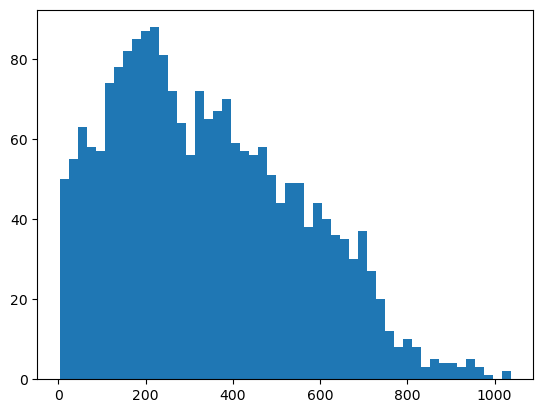

In [111]:
#print the distribution in column distance_km
plt.hist(distance['distance_km'], bins=50)
#print the pourcentage of row where distance_km is less than 50
print(f"Pourcentage of rows where distance_km is less than 50: {len(distance[distance['distance_km']<50]) / len(distance) * 100}%")

In [105]:
comparison_data = []

# Iterate over rows in the merged_dataset
for index, row in merged_dataset.iterrows():
    # Comparison for 20092012
    if row['matching20092012'] and not pd.isna(row['matching20092012']):
        # Find the matching city's row in the same dataset
        matched_row = merged_dataset[merged_dataset['CODGEO'] == row['matching20092012']]
        if not matched_row.empty:
            comparison_20092012 = {
                'CODGEO': row['CODGEO'],
                'period': '20092012',
                'current_result_2007': row['result_2007'],
                'current_result_2009': row['result_2009'],
                'current_result_2012': row['result_2012'],
                'current_result_2014': row['result_2014'],
                'current_result_2017': row['result_2017'],
                'current_result_2019': row['result_2019'],
                'current_result_2022': row['result_2022'],
                'matched_result_2007': matched_row['result_2007'].values[0],
                'matched_result_2009': matched_row['result_2009'].values[0],
                'matched_result_2012': matched_row['result_2012'].values[0],
                'matched_result_2014': matched_row['result_2014'].values[0],
                'matched_result_2017': matched_row['result_2017'].values[0],
                'matched_result_2019': matched_row['result_2019'].values[0],
                'matched_result_2022': matched_row['result_2022'].values[0],
                'difference_2012': row['result_2012'] - matched_row['result_2012'].values[0]
                if pd.notna(matched_row['result_2012'].values[0]) else None
            }
            comparison_data.append(comparison_20092012)
    
    # Comparison for 20142017
    if row['matching20142017'] and not pd.isna(row['matching20142017']):
        # Find the matching city's row in the same dataset
        matched_row = merged_dataset[merged_dataset['CODGEO'] == row['matching20142017']]
        if not matched_row.empty:
            comparison_20142017 = {
                'CODGEO': row['CODGEO'],
                'period': '20142017',
                'current_result_2007': row['result_2007'],
                'current_result_2009': row['result_2009'],
                'current_result_2012': row['result_2012'],
                'current_result_2014': row['result_2014'],
                'current_result_2017': row['result_2017'],
                'current_result_2019': row['result_2019'],
                'current_result_2022': row['result_2022'],
                'matched_result_2007': matched_row['result_2007'].values[0],
                'matched_result_2009': matched_row['result_2009'].values[0],
                'matched_result_2012': matched_row['result_2012'].values[0],
                'matched_result_2014': matched_row['result_2014'].values[0],
                'matched_result_2017': matched_row['result_2017'].values[0],
                'matched_result_2019': matched_row['result_2019'].values[0],
                'matched_result_2022': matched_row['result_2022'].values[0],
                'difference_2017': row['result_2017'] - matched_row['result_2017'].values[0]
                if pd.notna(matched_row['result_2017'].values[0]) else None
            }
            comparison_data.append(comparison_20142017)

# Create the comparison table as a DataFrame
comparison_table = pd.DataFrame(comparison_data)
comparison_table

,CODGEO,period,current_result_2007,current_result_2009,current_result_2012,current_result_2014,current_result_2017,current_result_2019,current_result_2022,matched_result_2007,matched_result_2009,matched_result_2012,matched_result_2014,matched_result_2017,matched_result_2019,matched_result_2022,difference_2012,difference_2017
0,01017,20092012,0.00,10.29,3.31,5.70,2.31,11.70,4.71,0.35,9.43,0.74,16.67,6.71,9.62,1.36,2.57,NaN
1,01022,20142017,0.45,18.06,1.96,5.97,4.68,10.04,2.37,0.88,9.85,0.14,4.97,3.95,6.60,1.54,NaN,0.73
2,01025,20142017,1.56,12.36,1.83,6.62,3.65,13.59,3.37,1.17,12.29,1.42,6.83,5.91,13.68,4.62,NaN,-2.26
3,01034,20142017,1.21,15.87,2.06,8.88,5.77,14.13,3.87,1.76,15.77,2.15,8.29,5.52,14.00,5.09,NaN,0.25
4,01052,20142017,2.35,9.26,3.76,4.59,4.44,9.79,3.11,0.51,3.64,1.88,4.81,18.38,9.35,5.00,NaN,-13.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12168,95628,20142017,1.63,23.12,3.54,11.52,5.47,19.40,4.82,1.17,22.39,1.71,12.47,5.14,20.34,7.64,NaN,0.33
12169,95637,20142017,1.55,23.54,2.57,10.88,9.06,18.46,4.50,1.58,12.63,2.23,11.59,9.13,18.23,4.49,NaN,-0.07
12170,95652,20142017,1.56,17.67,2.27,6.17,4.49,16.47,4.43,1.54,16.40,2.38,7.16,5.60,16.67,5.40,NaN,-1.11
12171,95676,20142017,1.55,17.37,2.88,7.96,2.99,11.96,4.73,1.34,13.48,1.59,8.39,6.59,16.00,7.23,NaN,-3.60


In [106]:
#Extract the number of row in comparison_table where period is equal to 20092012
print(len(comparison_table[comparison_table['period'] == '20092012']))
#Extract the number of row in comparison_table where period is equal to 20142017
print(len(comparison_table[comparison_table['period'] == '20142017']))

5521
6652


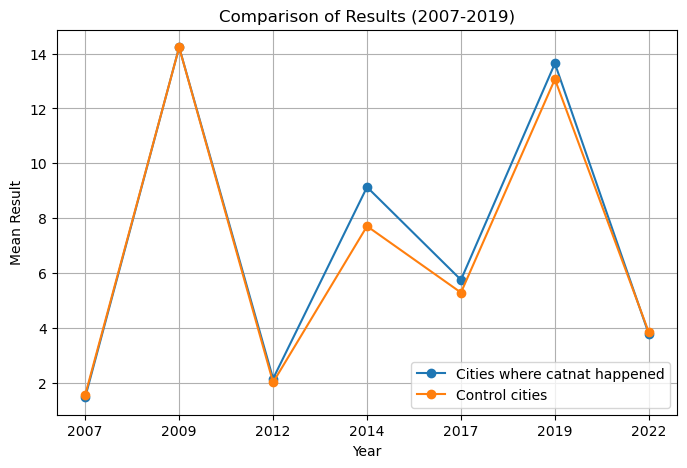

In [117]:
# Filter the dataset to include only rows where period = '20092012'
subset = comparison_table[comparison_table['period'] == '20092012']

# Calculate the means for the current and matched results
current_means = [
    subset['current_result_2007'].mean(),
    subset['current_result_2009'].mean(),
    subset['current_result_2012'].mean(),
    subset['current_result_2014'].mean(),
    subset['current_result_2017'].mean(),
    subset['current_result_2019'].mean(),
    subset['current_result_2022'].mean(),
]
matched_means = [
    subset['matched_result_2007'].mean(),
    subset['matched_result_2009'].mean(),
    subset['matched_result_2012'].mean(),
    subset['matched_result_2014'].mean(),
    subset['matched_result_2017'].mean(),
    subset['matched_result_2019'].mean(),
    subset['matched_result_2022'].mean(),
]

# Plot the graph
plt.figure(figsize=(8, 5))
x_labels = ['2007','2009', '2012', '2014','2017','2019','2022']
plt.plot(x_labels, current_means, marker='o', label='Cities where catnat happened')
plt.plot(x_labels, matched_means, marker='o', label='Control cities')

# Add titles and labels
plt.title('Comparison of Results (2007-2019)')
plt.xlabel('Year')
plt.ylabel('Mean Result')
plt.legend()
plt.grid(True)

# Show the graph
plt.show()

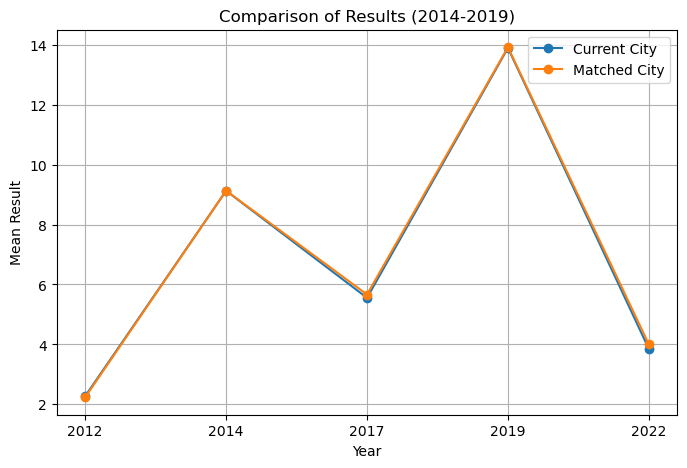

In [118]:
# Filter the dataset to include only rows where period = '20092012'
subset = comparison_table[comparison_table['period'] == '20142017']

# Calculate the means for the current and matched results
current_means = [
    subset['current_result_2012'].mean(),
    subset['current_result_2014'].mean(),
    subset['current_result_2017'].mean(),
    subset['current_result_2019'].mean(),
    subset['current_result_2022'].mean(),
]
matched_means = [
    subset['matched_result_2012'].mean(),
    subset['matched_result_2014'].mean(),
    subset['matched_result_2017'].mean(),
    subset['matched_result_2019'].mean(),
    subset['matched_result_2022'].mean(),
]

# Plot the graph
plt.figure(figsize=(8, 5))
x_labels = ['2012','2014', '2017', '2019','2022']
plt.plot(x_labels, current_means, marker='o', label='Current City')
plt.plot(x_labels, matched_means, marker='o', label='Matched City')

# Add titles and labels
plt.title('Comparison of Results (2014-2019)')
plt.xlabel('Year')
plt.ylabel('Mean Result')
plt.legend()
plt.grid(True)

# Show the graph
plt.show()

***
**Regression**
***

**Catnat from 2009 to 2012**

In [ ]:
## STEP 1. Build the paired dataset for diff-in-diff analysis.
# We use only cities that have a match in matching20092012 (treatment cities)
treatment = merged_dataset[merged_dataset['matching20092012'].notna()].copy()

# Their matched (control) cities are the ones whose CODGEO equals the treatment city’s matching20092012
control = merged_dataset[merged_dataset['CODGEO'].isin(treatment['matching20092012'])].copy()

# For identification, we assign a pair identifier.
# For treatment rows, let the pair_id be the CODGEO.
treatment['pair_id'] = treatment['CODGEO']

# For control rows, use the reverse mapping: the treatment row had matching20092012 equal to the control's CODGEO.
# Create a dictionary mapping: key = matched control's CODGEO, value = treatment city CODGEO.
pair_mapping = treatment.set_index('matching20092012')['CODGEO'].to_dict()
control['pair_id'] = control['CODGEO'].map(pair_mapping)

# Create a dummy variable to indicate treatment (1 for treatment cities, 0 for controls)
treatment['treatment'] = 1
control['treatment'] = 0

# Combine the paired observations
paired = pd.concat([treatment, control], ignore_index=True)

## STEP 2. Reshape from wide to long format.
result_cols = ['result_2007', 'result_2009', 'result_2012', 'result_2014',
               'result_2017', 'result_2019', 'result_2022']

paired_long = pd.melt(paired,
                      id_vars = ['CODGEO','pair_id','treatment','majority_20092012'],
                      value_vars = result_cols,
                      var_name = 'year',
                      value_name = 'result')

# Remove the "result_" prefix from the year and convert to integer.
paired_long['year'] = paired_long['year'].str.replace('result_', '').astype(int)

# Create a post-treatment indicator; treatment starts in 2012.
paired_long['post'] = (paired_long['year'] >= 2012).astype(int)
#convert parid_id into int
paired_long['pair_id'] = paired_long['pair_id'].astype(int)
paired_long['majority_20092012'] = paired_long.apply(lambda row: row['majority_20092012'] if row['treatment'] == 1 else 0, axis=1).astype(float )
paired_long['majority_20092012'] = paired_long['majority_20092012'].astype(str)  # Convert if needed
model = smf.ols('result ~ treatment * C(year) - treatment + C(pair_id)', data=paired_long).fit(cov_type='cluster', cov_kwds={'groups': paired_long['pair_id']})
print(model.summary())

## STEP 4. Alternative: Compute the synthetic diff manually.
# Pivot the long data so that in each pair-year we see the treatment and control outcomes.
pivot_df = paired_long.pivot_table(index=['pair_id','year'],
                                   columns='treatment', values='result').reset_index()
# Rename the columns (by convention let treatment group be labeled "1" and control "0")
pivot_df.columns = ['pair_id', 'year', 'control', 'treatment']
# Compute the within-pair difference.
pivot_df['diff'] = pivot_df['treatment'] - pivot_df['control']

# Now, average the differences for the pre-treatment and post-treatment periods
pre_diff = pivot_df[pivot_df['year'] < 2012].groupby('pair_id')['diff'].mean().rename('pre_diff')
post_diff = pivot_df[pivot_df['year'] >= 2012].groupby('pair_id')['diff'].mean().rename('post_diff')
diff_in_diff_estimate = (post_diff - pre_diff).mean()
print("Manual diff-in-diff estimate:", diff_in_diff_estimate)




## (Optional) Visualizing the results.
# For example, plot the evolution of differences over years for each pair (averaged across pairs):
mean_diff_by_year = pivot_df.groupby('year')['diff'].mean()
plt.figure(figsize=(8,5))
plt.plot(mean_diff_by_year.index, mean_diff_by_year.values, marker='o')
plt.title('Average Outcome Difference within Pairs by Year')
plt.xlabel('Year')
plt.ylabel('Diff (Treatment - Control)')
plt.axvline(x=2012, color='gray', linestyle='--', label='Treatment Start (2012)')
plt.legend()
plt.grid(True)
plt.show()


In [120]:
coef = model.params.filter(like='treatment:C(year)')
conf_int = model.conf_int().loc[coef.index]

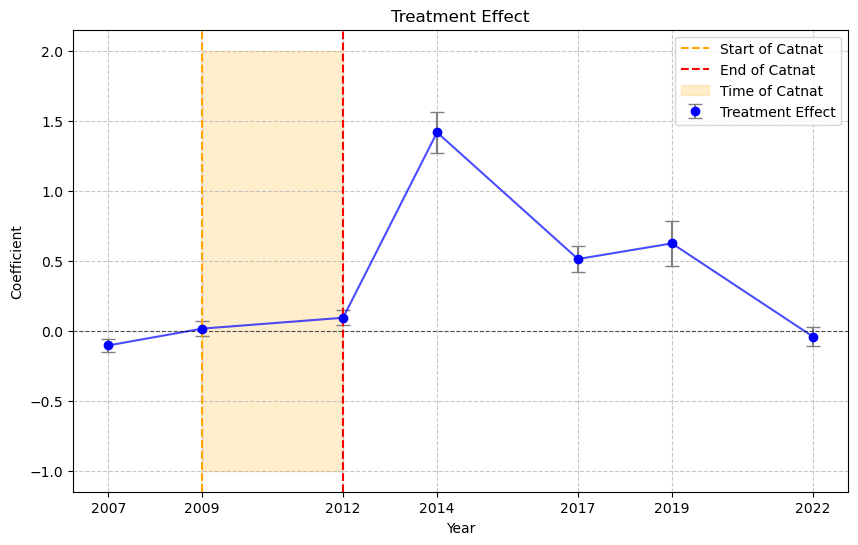

In [121]:
years = [int(term.split("[")[1].strip("]")) for term in coef.index]  # Extract years from 'treatment:C(year)[YYYY]'
coefficients = coef.values  # Coefficients
lower_bounds = conf_int[0].values  # Lower bound of confidence intervals
upper_bounds = conf_int[1].values  # Upper bound of confidence intervals

# Calculate error bars
errors = np.array([np.abs(coefficients - lower_bounds), np.abs(upper_bounds - coefficients)])

# Plotting the coefficients with error bars
plt.figure(figsize=(10, 6))

# Add error bars and connect points with lines
plt.errorbar(years, coefficients, yerr=errors, fmt='o', capsize=5, color='b', ecolor='gray', label='Treatment Effect')
plt.plot(years, coefficients, linestyle='-', color='blue', alpha=0.7)  # Connect points with straight lines

# Add vertical lines and shaded area for "time of catnat"
plt.axvline(x=2009, color='orange', linestyle='--', linewidth=1.5, label='Start of Catnat')
plt.axvline(x=2012, color='red', linestyle='--', linewidth=1.5, label='End of Catnat')
plt.fill_betweenx(
    [-1, 2], 2009, 2012, color='orange', alpha=0.2, label='Time of Catnat'
)  # Shade the region between 2009 and 2012

# Add labels and title
plt.axhline(0, color='black', linestyle='--', linewidth=0.8, alpha=0.6)  # Reference line at 0
plt.title('Treatment Effect')
plt.xlabel('Year')
plt.ylabel('Coefficient')
plt.xticks(years)  # Set x-axis ticks to years
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()

**Catnat from 2014 to 2017**

In [ ]:
## STEP 1. Build the paired dataset for diff-in-diff analysis.
# We use only cities that have a match in matching20092012 (treatment cities)
treatment = merged_dataset[merged_dataset['matching20142017'].notna()].copy()

# Their matched (control) cities are the ones whose CODGEO equals the treatment city’s matching20092012
control = merged_dataset[merged_dataset['CODGEO'].isin(treatment['matching20142017'])].copy()

# For identification, we assign a pair identifier.
# For treatment rows, let the pair_id be the CODGEO.
treatment['pair_id'] = treatment['CODGEO']

# For control rows, use the reverse mapping: the treatment row had matching20092012 equal to the control's CODGEO.
# Create a dictionary mapping: key = matched control's CODGEO, value = treatment city CODGEO.
pair_mapping = treatment.set_index('matching20142017')['CODGEO'].to_dict()
control['pair_id'] = control['CODGEO'].map(pair_mapping)

# Create a dummy variable to indicate treatment (1 for treatment cities, 0 for controls)
treatment['treatment'] = 1
control['treatment'] = 0

# Combine the paired observations
paired = pd.concat([treatment, control], ignore_index=True)

## STEP 2. Reshape from wide to long format.
result_cols = ['result_2012', 'result_2014',
               'result_2017', 'result_2019', 'result_2022']

paired_long = pd.melt(paired,
                      id_vars = ['CODGEO','pair_id','treatment'],
                      value_vars = result_cols,
                      var_name = 'year',
                      value_name = 'result')

# Remove the "result_" prefix from the year and convert to integer.
paired_long['year'] = paired_long['year'].str.replace('result_', '').astype(int)
paired_long['year'] = paired_long['year'].astype(int)
# Create a post-treatment indicator; treatment starts in 2012.
paired_long['post'] = (paired_long['year'] >= 2017).astype(int)
paired_long['pair_id'] = paired_long['pair_id'].astype(int)
## STEP 3. Diff-in-Diff Estimation with year and city (pair) effects.
# Our specification includes:
#   - treatment effect interacted with post indicator: treatment * post,
#   - fixed effects for pair_id (city/pair fixed effects) and for year.
model = smf.ols('result ~ treatment * C(year) - treatment + C(pair_id)', data=paired_long).fit(cov_type='cluster', cov_kwds={'groups': paired_long['pair_id']})
print(model.summary())

## STEP 4. Alternative: Compute the synthetic diff manually.
# Pivot the long data so that in each pair-year we see the treatment and control outcomes.
pivot_df = paired_long.pivot_table(index=['pair_id','year'],
                                   columns='treatment', values='result').reset_index()
# Rename the columns (by convention let treatment group be labeled "1" and control "0")
pivot_df.columns = ['pair_id', 'year', 'control', 'treatment']
# Compute the within-pair difference.
pivot_df['diff'] = pivot_df['treatment'] - pivot_df['control']

# Now, average the differences for the pre-treatment and post-treatment periods
pre_diff = pivot_df[pivot_df['year'] < 2017].groupby('pair_id')['diff'].mean().rename('pre_diff')
post_diff = pivot_df[pivot_df['year'] >= 2017].groupby('pair_id')['diff'].mean().rename('post_diff')
diff_in_diff_estimate = (post_diff - pre_diff).mean()
print("Manual diff-in-diff estimate:", diff_in_diff_estimate)




## (Optional) Visualizing the results.
# For example, plot the evolution of differences over years for each pair (averaged across pairs):
mean_diff_by_year = pivot_df.groupby('year')['diff'].mean()
plt.figure(figsize=(8,5))
plt.plot(mean_diff_by_year.index, mean_diff_by_year.values, marker='o')
plt.title('Average Outcome Difference within Pairs by Year')
plt.xlabel('Year')
plt.ylabel('Diff (Treatment - Control)')
plt.axvline(x=2017, color='gray', linestyle='--', label='Treatment Start (2017)')
plt.legend()
plt.grid(True)
plt.show()

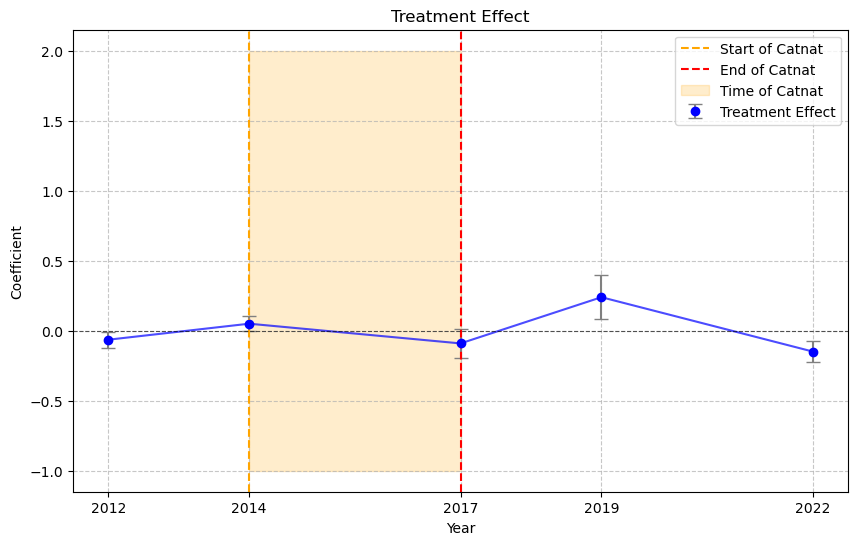

In [123]:
coef = model.params.filter(like='treatment:C(year)')[:]
conf_int = model.conf_int().loc[coef.index]
years = [int(term.split("[")[1].strip("]")) for term in coef.index]  # Extract years from 'treatment:C(year)[YYYY]'
coefficients = coef.values  # Coefficients
lower_bounds = conf_int[0].values  # Lower bound of confidence intervals
upper_bounds = conf_int[1].values  # Upper bound of confidence intervals

# Calculate error bars
errors = np.array([np.abs(coefficients - lower_bounds), np.abs(upper_bounds - coefficients)])

# Plotting the coefficients with error bars
plt.figure(figsize=(10, 6))

# Add error bars and connect points with lines
plt.errorbar(years, coefficients, yerr=errors, fmt='o', capsize=5, color='b', ecolor='gray', label='Treatment Effect')
plt.plot(years, coefficients, linestyle='-', color='blue', alpha=0.7)  # Connect points with straight lines

# Add vertical lines and shaded area for "time of catnat"
plt.axvline(x=2014, color='orange', linestyle='--', linewidth=1.5, label='Start of Catnat')
plt.axvline(x=2017, color='red', linestyle='--', linewidth=1.5, label='End of Catnat')
plt.fill_betweenx(
    [-1, 2], 2014, 2017, color='orange', alpha=0.2, label='Time of Catnat'
)  # Shade the region between 2009 and 2012

# Add labels and title
plt.axhline(0, color='black', linestyle='--', linewidth=0.8, alpha=0.6)  # Reference line at 0
plt.title('Treatment Effect')
plt.xlabel('Year')
plt.ylabel('Coefficient')
plt.xticks(years)  # Set x-axis ticks to years
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()

***
**Mapping**
***

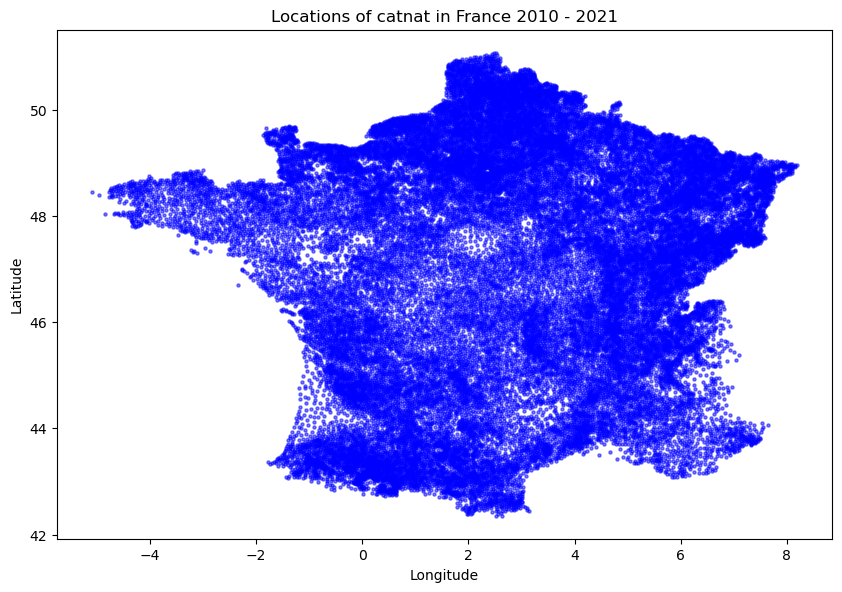

In [85]:
gdf_date = gpd.GeoDataFrame(
    merged_dataset,
    geometry=gpd.points_from_xy(merged_dataset.longitude, merged_dataset.latitude),
)

#plot the map
fig,ax = plt.subplots(figsize=(10, 10))
gdf_date.plot(ax=ax,markersize =5, color='blue', alpha=0.5)
plt.title('Locations of catnat in France 2010 - 2021')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

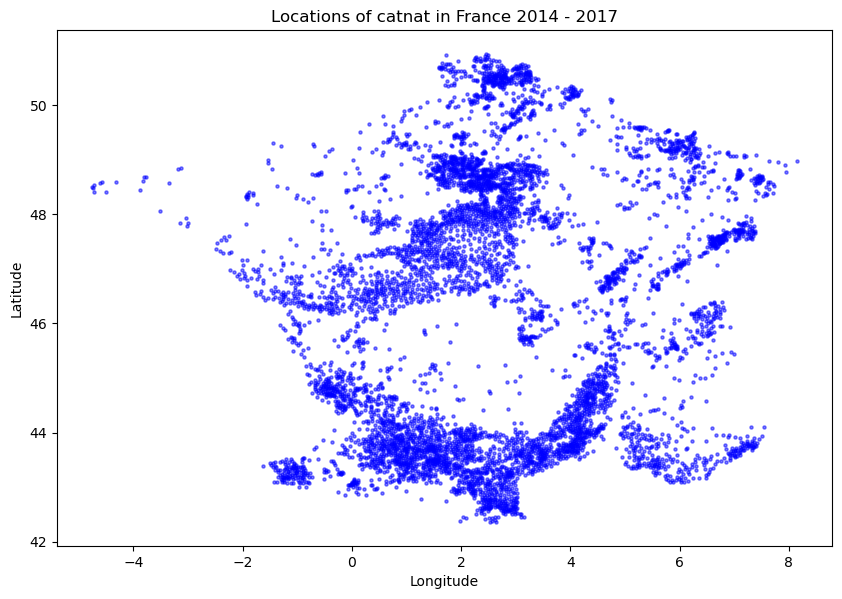

In [86]:
subdataset = merged_dataset[~merged_dataset['matching20142017'].isna()]

gdf_date = gpd.GeoDataFrame(
    subdataset,
    geometry=gpd.points_from_xy(subdataset.longitude, subdataset.latitude),
)

#plot the map
fig,ax = plt.subplots(figsize=(10, 10))
gdf_date.plot(ax=ax,markersize =5, color='blue', alpha=0.5)
plt.title('Locations of catnat in France 2014 - 2017')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

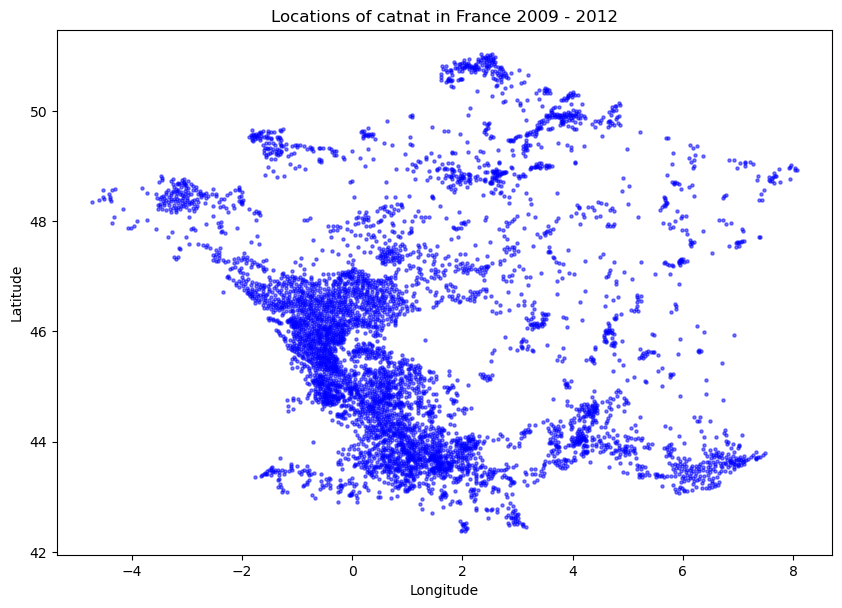

In [87]:
subdataset = merged_dataset[~merged_dataset['matching20092012'].isna()]

gdf_date = gpd.GeoDataFrame(
    subdataset,
    geometry=gpd.points_from_xy(subdataset.longitude, subdataset.latitude),
)

#plot the map
fig,ax = plt.subplots(figsize=(10, 10))
gdf_date.plot(ax=ax,markersize =5, color='blue', alpha=0.5)
plt.title('Locations of catnat in France 2009 - 2012')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()